# CS2 Event dataset

Create CS2 event dataset from the heterogeneous shapshot graphs. Features to keep track of (P - player, M - map, U - universal):

In [1]:
from awpy import Demo

import torch
import torch.nn.functional as F
from torch_geometric.data import DataLoader, HeteroData
from torch_geometric.loader import DataLoader

import pandas as pd
import polars as pl
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor

import shap
shap.initjs()


import time
import json
import sys
import os

pd.set_option('display.max_columns', 100)
pd.set_option('future.no_silent_downcasting', True)

pl.Config.set_tbl_rows(10)
pd.set_option('display.max_columns', 50)

sys.path.append(os.path.abspath('../../../package'))

from CS2.graph import TabularGraphSnapshot, HeteroGraphSnapshot, TemporalHeteroGraphSnapshot
from CS2.token import Tokenizer
from CS2.preprocess import Dictionary, NormalizePosition, NormalizeTabularGraphSnapshot, ImputeTabularGraphSnapshot
from CS2.visualize import HeteroGraphVisualizer, HeteroGNNRoundAnalyzer

PATH_GRAPH_DATA = '../../../data/matches-processed/cs2/hetero-graph/'
PATH_TEMP_GRAPH_DATA = '../../../data/matches-processed/cs2/temporal-hetero-graph/'
PATH_MODELS = '../../../model/tgn/'



class CSTemporalDataLoader(DataLoader):

    def __init__(self, dataset, batch_size=1, shuffle=False, *args, **kwargs):
        super().__init__(dataset, batch_size=batch_size, shuffle=shuffle, *args, **kwargs)

        self._dataset = dataset
        self._batch_size = batch_size
        self._shuffle = shuffle

    def __iter__(self):
        # Optionally shuffle the dataset
        indices = list(range(len(self._dataset)))
        if self._shuffle:
            torch.random.manual_seed(42)  # Ensure reproducibility if needed
            indices = torch.randperm(len(self._dataset)).tolist()

        # Yield batches of DTDGs
        batch = []
        for idx in indices:
            batch.append(self._dataset[idx])
            if len(batch) == self._batch_size:
                yield batch
                batch = []

        # Yield the last smaller batch if it exists
        if batch:
            yield batch


C:\Users\szmid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Features to examine:


  - P. position changes (X, Y, Z) ✅
  - P. velocity changes (X, Y, Z) ✅
  - P. look direction changes ✅
  - P. entered bombsite ✅
  - P. left bombsite ✅
  - P. travelled to new map area 
  - P. actual map area 

  - P. changed to primary weapon ✅
  - P. switched primary weapon ✅
  - P. primary weapon ✅
  - P. changed to secondary weapon ✅
  - P. switched secondary weapon ✅
  - P. secondary weapon ✅
  - P. is shooting / throwing a grenade ✅
  - P. got low on ammunition ✅

  - P. eliminated an opponent ✅
  - P. lost health ✅
  - P. lost armor ✅
  - P. got eliminated ✅

  - P. was spotted ✅
  - P. got flashed ✅
  - P. started reloading ✅
  - P. finished reloading ✅
  - P. scoped in  ✅
  - P. scoped out ✅
  - P. started defusing ✅
  - P. stopped defusing ✅

  - M. map part got set on fire ✅
  - M. map part molotov extinguished ✅
  - M. nodes burning on map part ✅
  - M. map part got smoked ✅
  - M. map part smoke ended ✅
  - M. active smokes on map part ✅

  - U. bomb got dropped ✅
  - U. bomb was picked up ✅
  - U. bomb getting planted ✅
  - U. bomb got planted ✅
  - U. bombsite the bomb was planted on (A or B) ✅
  - U. bomb position in the 9x9 matrix ✅

  - PRED. predicted win probability for the snapshot 

### Event dataset creation

In [2]:
# Data
data = torch.load(PATH_GRAPH_DATA + '100000.pt', weights_only=False)
temp_data = torch.load(PATH_TEMP_GRAPH_DATA + '100000.pt', weights_only=False)


# Load Model Code
model_class_code = ''
with open(PATH_MODELS + '241025_3_best/' + 'gnn_code.txt', 'r') as f:
    model_class_code = f.read()
exec(model_class_code)

# Load Model
model = torch.load(PATH_MODELS + '/241025_3_best/epoch_1.pt', weights_only=False)

In [3]:
def get_player_data(graph):

    # X, Y, Z
    X = graph['player'].x[:, 0]
    Y = graph['player'].x[:, 1]
    Z = graph['player'].x[:, 2]

    # View direction
    view_X = graph['player'].x[:, 3]
    view_Y = graph['player'].x[:, 4]

    # Velocity
    vel_X = graph['player'].x[:, 5]
    vel_Y = graph['player'].x[:, 6]
    vel_Z = graph['player'].x[:, 7]

    # Health and armor
    health = graph['player'].x[:, 8]
    armor = graph['player'].x[:, 9]

    # Active weapon magazine ammo left %
    ammo_left_percent = graph['player'].x[:, 12]

    # Flashed
    flashed = graph['player'].x[:, 16]

    # Is alive and is CT
    is_alive = graph['player'].x[:, 22]
    is_ct = graph['player'].x[:, 23]

    # Shooting
    shooting = graph['player'].x[:, 24]

    # Spotted
    spotted = graph['player'].x[:, 29]

    # Is scoped
    is_scoped = graph['player'].x[:, 30]
    zoom_lvl = graph['player'].x[:, 34]

    # Is defusing
    is_defusing = graph['player'].x[:, 31]

    # Is reloading
    is_reloading = graph['player'].x[:, 32]

    # Is in bombsight
    is_in_bombsight = graph['player'].x[:, 33]

    # Stat kills
    kills = graph['player'].x[:, 36]

    # Actual nearenst map node
    positions = []
    for node in graph['map'].x:
        if str(node[0].tolist())[:2] not in positions:
            positions.append(str(node[0].tolist())[:2])
    
    position_flags = np.zeros([10, len(positions)])

    nearest_map_node = graph[('player', 'closest_to', 'map')].edge_index[1]
    for node_id in range(len(nearest_map_node)):
        position_flags[node_id][int(str(graph['map'].x[nearest_map_node[node_id]][0].tolist())[:2]) - 10] = 1

    position_flags = torch.tensor(position_flags)

    # Inventory
    inventory = graph['player'].x[:, 53:95]

    # Active weapon
    active_weapon = graph['player'].x[:, 95:138]

    # Stack the columns together
    player_data = torch.stack([X, Y, Z, view_X, view_Y, vel_X, vel_Y, vel_Z, health, armor, ammo_left_percent, flashed, is_alive, is_ct, shooting, spotted, is_scoped, zoom_lvl, is_defusing, is_reloading, is_in_bombsight, kills], dim=1)
    player_data = torch.cat([player_data, position_flags, inventory, active_weapon], dim=1)

    # Get the column names
    column_names = [
        '_X', '_Y', '_Z', '_view_X', '_view_Y', '_vel_X', '_vel_Y', '_vel_Z', '_health', '_armor', '_ammo_left_percent', '_flashed', '_is_alive', '_is_ct', '_shooting', '_spotted', '_is_scoped', '_zoom_lvl', '_is_defusing', '_is_reloading', '_is_in_bombsight', '_kills',
        '_a', '_a_balcony', '_aps', '_arch', '_b', '_back_ally', '_banana', '_bridge', '_ct_start', '_deck', '_graveyard', '_kitchen', '_library', '_lower_mid', '_mid', '_pit', '_quad', '_ruins', '_sec_mid', '_sec_mid_balcony', '_t_aps', '_t_ramp', '_t_spawn', '_top_mid', '_under', '_upstairs',
        '_inventory_C4', '_inventory_Taser', '_inventory_USP-S', '_inventory_P2000', '_inventory_Glock-18', '_inventory_Dual Berettas', '_inventory_P250', '_inventory_Tec-9', '_inventory_CZ75 Auto', '_inventory_Five-SeveN', '_inventory_Desert Eagle', '_inventory_R8 Revolver', '_inventory_MAC-10', '_inventory_MP9', '_inventory_MP7', '_inventory_MP5-SD', '_inventory_UMP-45', '_inventory_PP-Bizon', '_inventory_P90', '_inventory_Nova', '_inventory_XM1014', '_inventory_Sawed-Off', '_inventory_MAG-7', '_inventory_M249', '_inventory_Negev', '_inventory_FAMAS', '_inventory_Galil AR', '_inventory_AK-47', '_inventory_M4A4', '_inventory_M4A1-S', '_inventory_SG 553', '_inventory_AUG', '_inventory_SSG 08', '_inventory_AWP', '_inventory_G3SG1', '_inventory_SCAR-20', '_inventory_HE Grenade', '_inventory_Flashbang', '_inventory_Smoke Grenade', '_inventory_Incendiary Grenade', '_inventory_Molotov', '_inventory_Decoy Grenade', 
        '_active_weapon_C4', '_active_weapon_Knife', '_active_weapon_Taser', '_active_weapon_USP-S', '_active_weapon_P2000', '_active_weapon_Glock-18', '_active_weapon_Dual Berettas', '_active_weapon_P250', '_active_weapon_Tec-9', '_active_weapon_CZ75 Auto', '_active_weapon_Five-SeveN', '_active_weapon_Desert Eagle', '_active_weapon_R8 Revolver', '_active_weapon_MAC-10', '_active_weapon_MP9', '_active_weapon_MP7', '_active_weapon_MP5-SD', '_active_weapon_UMP-45', '_active_weapon_PP-Bizon', '_active_weapon_P90', '_active_weapon_Nova', '_active_weapon_XM1014', '_active_weapon_Sawed-Off', '_active_weapon_MAG-7', '_active_weapon_M249', '_active_weapon_Negev', '_active_weapon_FAMAS', '_active_weapon_Galil AR', '_active_weapon_AK-47', '_active_weapon_M4A4', '_active_weapon_M4A1-S', '_active_weapon_SG 553', '_active_weapon_AUG', '_active_weapon_SSG 08', '_active_weapon_AWP', '_active_weapon_G3SG1', '_active_weapon_SCAR-20', '_active_weapon_HE Grenade', '_active_weapon_Flashbang', '_active_weapon_Smoke Grenade', '_active_weapon_Incendiary Grenade', '_active_weapon_Molotov', '_active_weapon_Decoy Grenade',     
    ]

    # Create column names for all 10 players
    player_column_names = []

    for i in range(10):
        for column in column_names:
            if i < 5:
                player_column_names.append('CT' + str(i) + column)
            else:
                player_column_names.append('T' + str(i) + column)

    # Flatten the player data
    player_data = player_data.flatten()

    return player_column_names, player_data

def get_map_data(graph):
    
    positions = {}
    for node in graph['map'].x:
        if str(node[0].tolist())[:2] not in positions:
            positions[str(node[0].tolist())[:2]] = [node[7].tolist(), node[8].tolist()]
        else:
            positions[str(node[0].tolist())[:2]][0] += node[7].tolist()
            positions[str(node[0].tolist())[:2]][1] += node[8].tolist()

    flattened_positions = []
    pos_names = []
    for key in positions:
        pos_names.append(key + '_burning_nodes')
        flattened_positions.append(positions[key][0])
        pos_names.append(key + '_smoked_nodes')
        flattened_positions.append(positions[key][1])

    return pos_names, flattened_positions

def get_universal_data(graph):

    # Round and remaining time
    round_num = float(graph.y['round'])
    remaining_time = float(graph.y['remaining_time'])

    # Bomb dropped
    bomb_dropped = float(graph.y['is_bomb_dropped'])

    # Bomb being planted
    bomb_being_planted = float(graph.y['is_bomb_being_planted'])

    # Bomb planted on site
    bomb_on_A = float(graph.y['is_bomb_planted_at_A_site'])
    bomb_on_B = float(graph.y['is_bomb_planted_at_B_site'])

    # Bomb mx pos
    # bomb_mx_pos1 = float(graph.y['bomb_mx_pos1'])
    # bomb_mx_pos2 = float(graph.y['bomb_mx_pos2'])
    # bomb_mx_pos3 = float(graph.y['bomb_mx_pos3'])
    # bomb_mx_pos4 = float(graph.y['bomb_mx_pos4'])
    # bomb_mx_pos5 = float(graph.y['bomb_mx_pos5'])
    # bomb_mx_pos6 = float(graph.y['bomb_mx_pos6'])
    # bomb_mx_pos7 = float(graph.y['bomb_mx_pos7'])
    # bomb_mx_pos8 = float(graph.y['bomb_mx_pos8'])
    # bomb_mx_pos9 = float(graph.y['bomb_mx_pos9'])

    universal_column_names = [
        'round', 'remaining_time', 'bomb_dropped', 'bomb_being_planted', 'bomb_on_A', 'bomb_on_B' 
        # 'bomb_mx_pos1', 'bomb_mx_pos2', 'bomb_mx_pos3', 'bomb_mx_pos4', 'bomb_mx_pos5', 'bomb_mx_pos6', 'bomb_mx_pos7', 'bomb_mx_pos8', 'bomb_mx_pos9'
    ]

    universal_data = [round_num, remaining_time, bomb_dropped, bomb_being_planted, bomb_on_A, bomb_on_B] #bomb_mx_pos1, bomb_mx_pos2, bomb_mx_pos3, bomb_mx_pos4, bomb_mx_pos5, bomb_mx_pos6, bomb_mx_pos7, bomb_mx_pos8, bomb_mx_pos9]

    return universal_column_names, universal_data



def get_round_data(round_graphs, predictions):

    graph_infos = []
    column_names = []

    for graph in round_graphs:
        
        pn, p = get_player_data(graph)
        mn, m = get_map_data(graph)
        un, u = get_universal_data(graph)

        column_names = pn + mn + un
        graph_concat_data = np.concatenate([p, m, u])

        graph_infos.append(graph_concat_data)

    rdf = pd.DataFrame(graph_infos, columns=column_names)
    filler_zeros_num = len(rdf) - len(predictions)
    rdf['y'] = np.zeros(filler_zeros_num).tolist() + predictions
    round_backup = rdf['round'].copy()
    y_backup = rdf['y'].copy()

    cdf = rdf.diff().shift(-1).add_suffix('_change')
    cdf = cdf[filler_zeros_num:-1]
    cdf['round'] = round_backup[filler_zeros_num:-1]
    cdf['y'] = y_backup[filler_zeros_num:-1]

    return cdf

def process_match(data, temp_data, model, last_round=24):

    rcdf = None

    for r in range(1, last_round):

        analyzer = HeteroGNNRoundAnalyzer()

        round_data = analyzer._EXT_get_round_data(data, r)
        predictions = analyzer.analyze_round(temp_data, model, r, return_predictions=True)

        round_changes = get_round_data(round_data, predictions)

        if rcdf is None:
            rcdf = round_changes
        else:
            rcdf = pd.concat([rcdf, round_changes])

    rcdf['idx'] = rcdf.reset_index().index
    return rcdf


In [4]:
cdf = process_match(data, temp_data, model, 16)

### Ridge

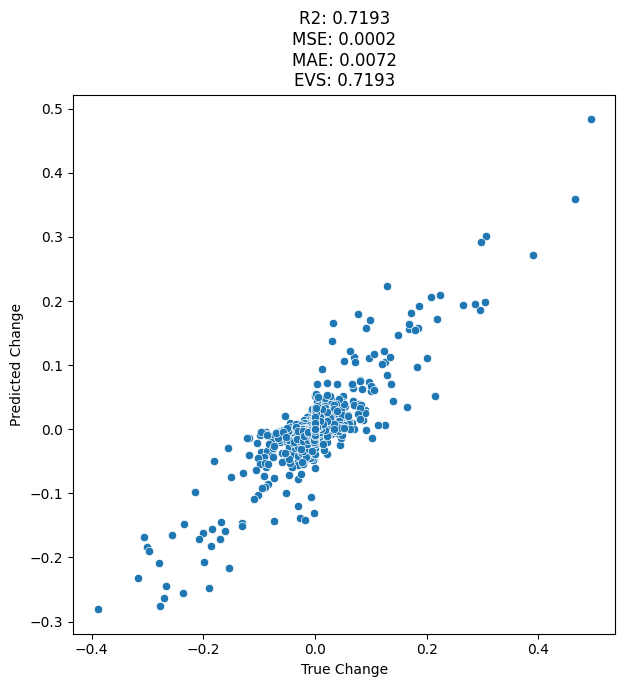

In [5]:
lr = Ridge(alpha=0.05)
lr.fit(cdf.drop(columns=['y_change']), cdf['y_change'])

y_pred = lr.predict(cdf.drop(columns=['y_change']))
y_true = cdf['y_change']

r2  = round(r2_score(y_true, y_pred), 4)
mse = round(mean_squared_error(y_true, y_pred), 4)
mae = round(mean_absolute_error(y_true, y_pred), 4)
evs = round(explained_variance_score(y_true, y_pred), 4)

plt.figure(figsize=(7, 7))
sns.scatterplot(x=y_true, y=y_pred)
plt.title(f'R2: {r2}\nMSE: {mse}\nMAE: {mae}\nEVS: {evs}')
plt.xlabel('True Change')
plt.ylabel('Predicted Change');

In [6]:
feature_importance = pd.DataFrame(np.array([cdf.drop(columns=['y_change']).columns.tolist(), np.round(lr.coef_, 4)]).T, columns=['column', 'importance'])
feature_importance = feature_importance.round(5)
feature_importance = feature_importance.sort_values('importance', ascending=False)
feature_importance

,column,importance
541,CT4_armor_change,0.1843
417,CT3_is_defusing_change,0.1749
32,CT0_graveyard_change,0.1502
347,CT2_inventory_AWP_change,0.1433
1085,T8_kills_change,0.1375
...,...,...
1331,10_smoked_nodes_change,-0.0002
536,CT4_view_Y_change,-0.0001
1083,T8_is_reloading_change,-0.0001
559,CT4_back_ally_change,-0.0


### SHAP

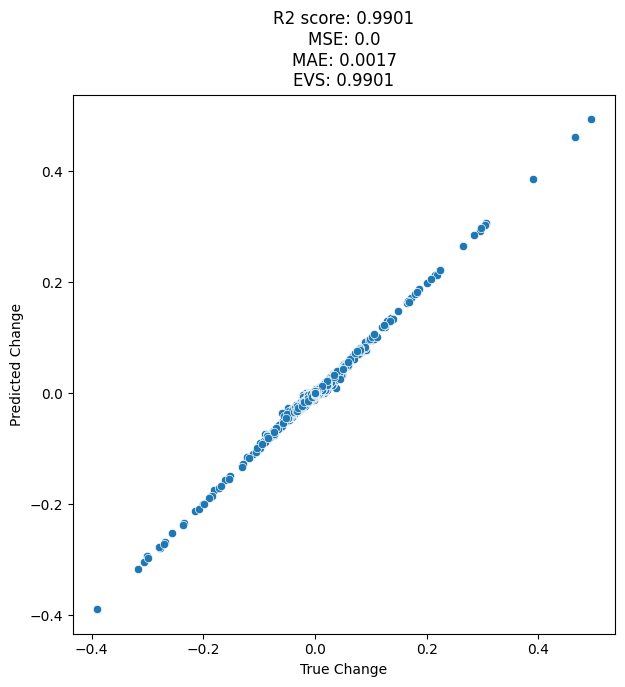

In [21]:
# Data
X = cdf.drop(columns=['y_change', 'idx', 'y'])
y = cdf['y_change']

# Random forest regression training
model = XGBRegressor(n_estimators=300, random_state=42)
model.fit(X, y)

# Prediction
y_pred = model.predict(X)
y_true = y

# Metrics
r2  = round(r2_score(y, y_pred), 4)
mse = round(mean_squared_error(y, y_pred), 4)
mae = round(mean_absolute_error(y, y_pred), 4)
evs = round(explained_variance_score(y, y_pred), 4)

# Plot results
plt.figure(figsize=(7, 7))
sns.scatterplot(x=y_true, y=y_pred)
plt.title(f'R2 score: {r2}\nMSE: {mse}\nMAE: {mae}\nEVS: {evs}')
plt.xlabel('True Change')
plt.ylabel('Predicted Change');

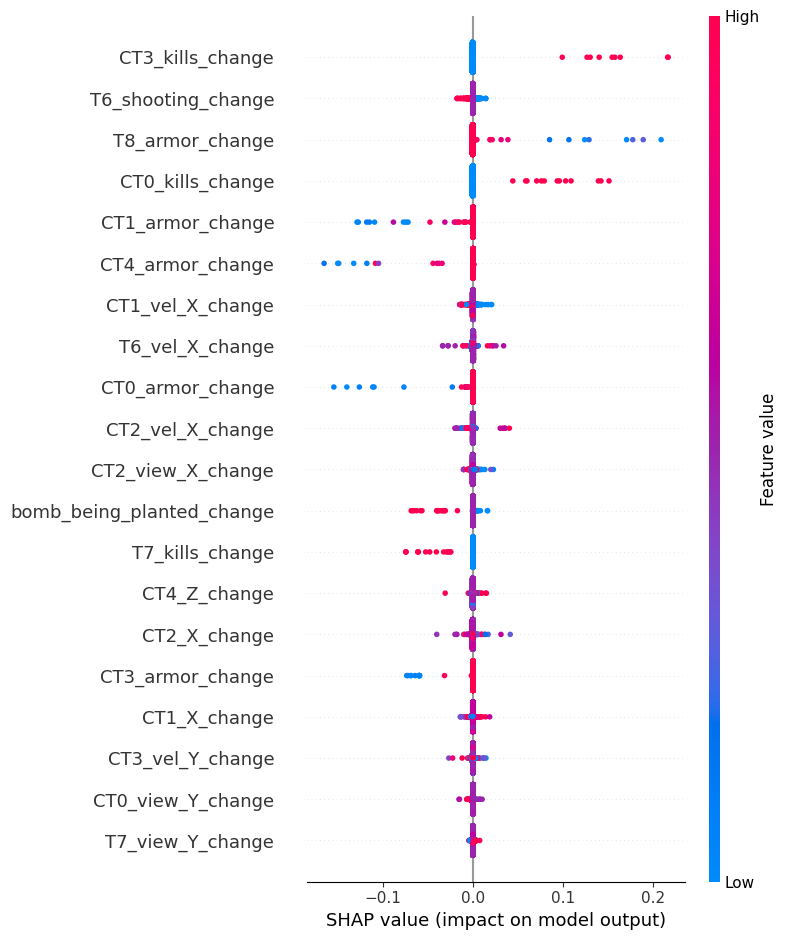

In [22]:
# SHAP explainer inicialization
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# SHAP summary plot
shap.summary_plot(shap_values, X)

In [23]:
cdf['round'].unique()

array([0.04166667, 0.08333334, 0.125     , 0.16666667, 0.20833333,
       0.25      , 0.29166666, 0.33333334, 0.375     , 0.41666666,
       0.45833334, 0.5       , 0.54166669, 0.58333331, 0.625     ])

In [24]:
selected_round_start_idx = int(cdf[cdf['round'].round(2) == 0.29].iloc[0]['idx'])
selected_round_end_idx = int(cdf[cdf['round'].round(2) == 0.29].iloc[-1]['idx'])

selected_round_data = cdf.iloc[selected_round_start_idx:selected_round_end_idx, :].drop(columns=['y_change', 'idx', 'y'])
round_shap_values = shap_values[selected_round_start_idx:selected_round_end_idx, :]

In [25]:
shap.force_plot(explainer.expected_value, round_shap_values[296:310, :], selected_round_data.iloc[296:310, :])

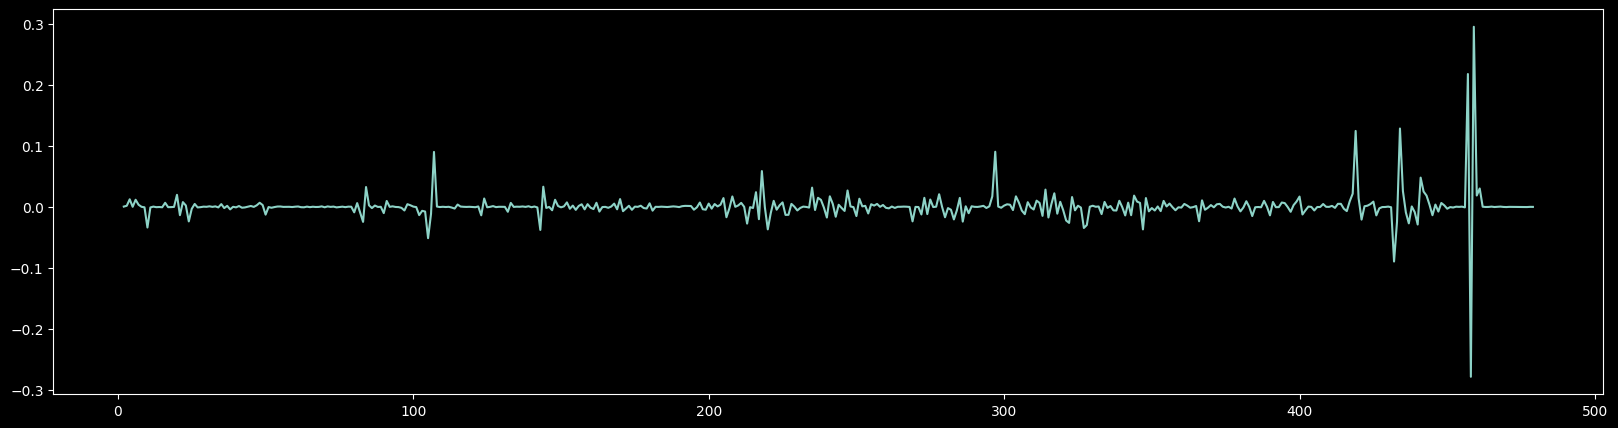

In [48]:
fig, ax = plt.subplots(figsize=(20, 5))
plt.plot(cdf.iloc[selected_round_start_idx:selected_round_end_idx, :]['y_change'])

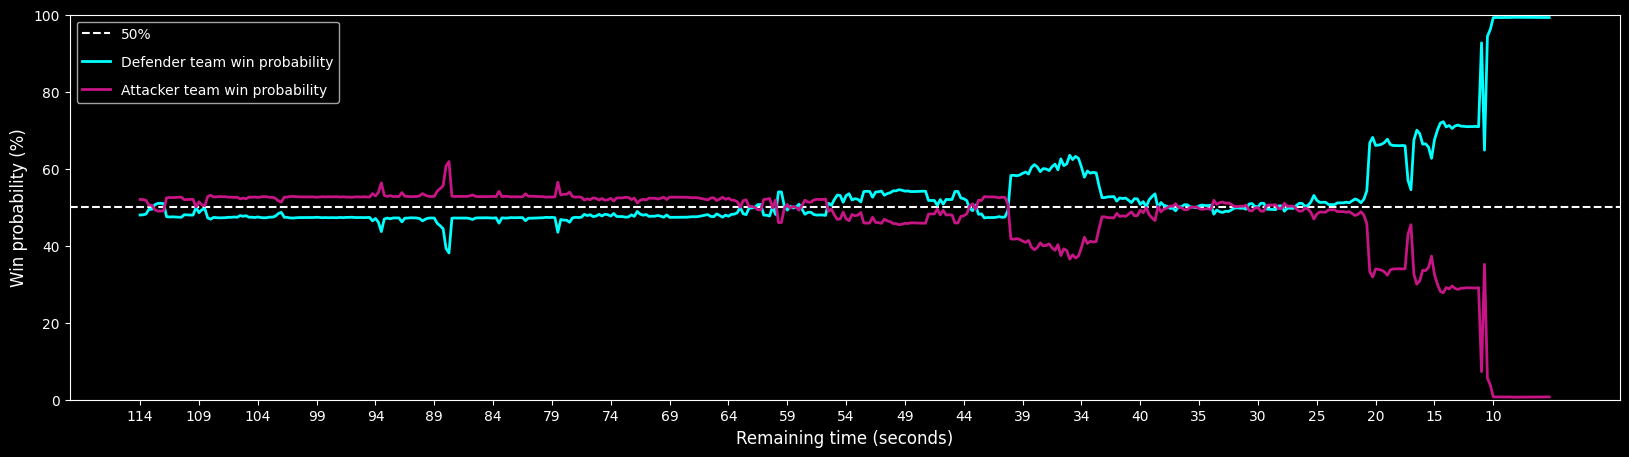

In [44]:
analyzer = HeteroGNNRoundAnalyzer()
analyzer.analyze_round(temp_data, model, 7)

In [38]:
frame_df = pd.DataFrame(np.array([selected_round_data.columns.tolist(), round_shap_values[295]]).T, columns=['column', 'shap'])
frame_df['shap'] = frame_df['shap'].astype(float).round(5)
frame_df = frame_df.sort_values('shap', ascending=False)
frame_df.head(5)

,column,shap
1272,T9_inventory_AK-47_change,0.07564
154,CT1_kills_change,0.02805
1206,T9_armor_change,0.01053
1202,T9_vel_X_change,0.00159
671,T5_vel_Y_change,0.00105


### Flattened 20 snapshots approach

In [5]:
fdf = cdf.copy().reset_index(drop=True)

fdf_shifted_1 = fdf.shift(1)
fdf_shifted_2 = fdf.shift(2)
fdf_shifted_3 = fdf.shift(3)
fdf_shifted_4 = fdf.shift(4)
fdf_shifted_5 = fdf.shift(5)
fdf_shifted_6 = fdf.shift(6)
fdf_shifted_7 = fdf.shift(7)
fdf_shifted_8 = fdf.shift(8)

fdf = pd.concat([
    fdf, 
    fdf_shifted_1.add_suffix('_1'), 
    fdf_shifted_2.add_suffix('_2'), 
    fdf_shifted_3.add_suffix('_3'), 
    fdf_shifted_4.add_suffix('_4'), 
    fdf_shifted_5.add_suffix('_5'), 
    fdf_shifted_6.add_suffix('_6'), 
    fdf_shifted_7.add_suffix('_7'), 
    fdf_shifted_8.add_suffix('_8')
], axis=1).fillna(0)

fdf

,CT0_X_change,CT0_Y_change,CT0_Z_change,CT0_view_X_change,CT0_view_Y_change,CT0_vel_X_change,CT0_vel_Y_change,CT0_vel_Z_change,CT0_health_change,CT0_armor_change,CT0_ammo_left_percent_change,CT0_flashed_change,CT0_is_alive_change,CT0_is_ct_change,CT0_shooting_change,CT0_spotted_change,CT0_is_scoped_change,CT0_zoom_lvl_change,CT0_is_defusing_change,CT0_is_reloading_change,CT0_is_in_bombsight_change,CT0_kills_change,CT0_inventory_C4_change,CT0_inventory_Taser_change,CT0_inventory_USP-S_change,...,26_smoked_nodes_change_8,27_burning_nodes_change_8,27_smoked_nodes_change_8,28_burning_nodes_change_8,28_smoked_nodes_change_8,29_burning_nodes_change_8,29_smoked_nodes_change_8,30_burning_nodes_change_8,30_smoked_nodes_change_8,31_burning_nodes_change_8,31_smoked_nodes_change_8,32_burning_nodes_change_8,32_smoked_nodes_change_8,33_burning_nodes_change_8,33_smoked_nodes_change_8,34_burning_nodes_change_8,34_smoked_nodes_change_8,35_burning_nodes_change_8,35_smoked_nodes_change_8,remaining_time_change_8,bomb_dropped_change_8,bomb_being_planted_change_8,bomb_on_A_change_8,bomb_on_B_change_8,y_change_8
0,-0.011011,0.010940,0.000126,0.006693,0.011553,-0.003563,-0.002650,0.005963,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
1,-0.011748,0.010296,0.000799,0.005401,0.012946,-0.005791,-0.006304,0.000871,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
2,-0.012377,0.009535,-0.000317,0.001290,0.001916,-0.003468,-0.004260,-0.005388,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
3,-0.013814,0.005599,-0.000260,0.001528,-0.000929,-0.011731,-0.027574,-0.000791,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
4,-0.013543,0.007634,-0.000140,0.000118,0.000000,0.006898,0.020828,0.000791,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.002033,0.0,0.0,0.0,0.0,0.000457
475,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.002033,0.0,0.0,0.0,0.0,-0.000076
476,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.002033,0.0,0.0,0.0,0.0,-0.000306
477,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.002033,0.0,0.0,0.0,0.0,0.000040


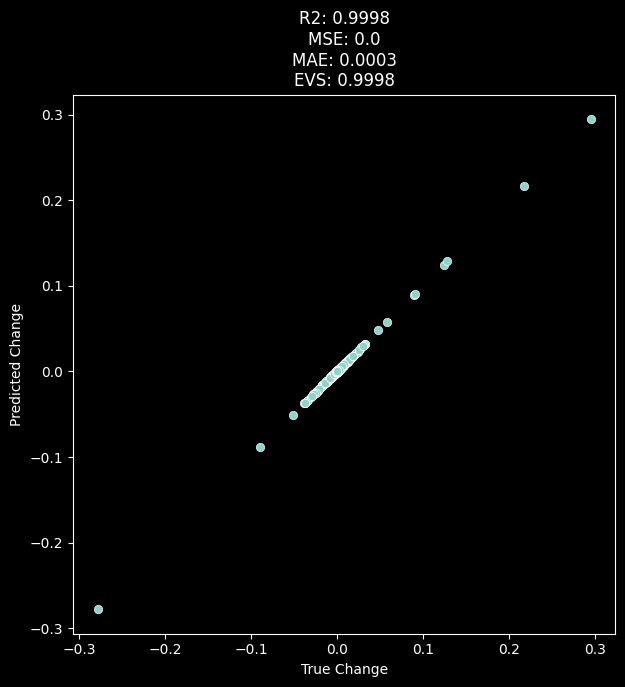

In [6]:
xgb = XGBRegressor()
xgb.fit(fdf.drop(columns=['y_change']), fdf['y_change'])

y_pred = xgb.predict(fdf.drop(columns=['y_change']))
y_true = fdf['y_change']

r2  = round(r2_score(y_true, y_pred), 4)
mse = round(mean_squared_error(y_true, y_pred), 4)
mae = round(mean_absolute_error(y_true, y_pred), 4)
evs = round(explained_variance_score(y_true, y_pred), 4)

plt.figure(figsize=(7, 7))
sns.scatterplot(x=y_true, y=y_pred)
plt.title(f'R2: {r2}\nMSE: {mse}\nMAE: {mae}\nEVS: {evs}')
plt.xlabel('True Change')
plt.ylabel('Predicted Change');

In [7]:
feature_importance = pd.DataFrame(np.array([fdf.drop(columns=['y_change']).columns.tolist(), np.round(xgb.feature_importances_, 4)]).T, columns=['column', 'importance'])
feature_importance = feature_importance.round(5)
feature_importance = feature_importance.sort_values('importance', ascending=False)
feature_importance

,column,importance
10150,y_change_8,1e-04
7409,T6_X_change_6,1e-04
3600,CT2_view_X_change_3,1e-04
3604,CT2_vel_Z_change_3,1e-04
4727,CT2_Z_change_4,1e-04
...,...,...
3548,CT1_inventory_HE Grenade_change_3,0.0
3549,CT1_inventory_Flashbang_change_3,0.0
3550,CT1_inventory_Smoke Grenade_change_3,0.0
3551,CT1_inventory_Incendiary Grenade_change_3,0.0


In [ ]:
# SHAP explainer inicialization
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(fdf.drop(columns=['y_change']))

# SHAP plot all snapshots
shap.summary_plot(shap_values, fdf.drop(columns=['y_change']))

In [ ]:
# Force plot to show the SHAP values for all snapshots in the dataset, so that the X axis is the snapshot index, and the Y axis is the predicted change in the round outcome
# With shape values, we can see the importance of each feature in the prediction of the change in the round outcome
shap.force_plot(explainer.expected_value, shap_values[230:270, :1270], fdf.iloc[230:270, :1270].drop(columns=['y_change']))